# Western Power Smart Meter

How to to use timeseries data for prediction?

![mixed network](https://miro.medium.com/max/1153/1*o_OrUlFOXuGtJFKn3LpGKw.png)

For more information:

- [Forecastingstockpriceswitha featurefusionLSTM-CNNmodelusingdifferentrepresentationsofthesamedata](https://journals.plos.org/plosone/article/file?type=printable&id=10.1371/journal.pone.0212320)
- [Get Started with Using CNN+LSTM for Forecasting](https://towardsdatascience.com/get-started-with-using-cnn-lstm-for-forecasting-6f0f4dde5826)

In [1]:
%matplotlib inline


[1000,10,3,4]

[[1,2,2], --1pm
[23,4,5], --2pm
[2,2,2]]  --3pm

In [2]:
import pandas as pd
import numpy as np
from random import sample, randint
import os, datetime
from pathlib import Path
import itertools
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import logging
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings, sklearn
import pickle
# Import the email modules we'll need
from sklearn.base import BaseEstimator, ClassifierMixin
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPool1D, Flatten, AveragePooling1D
import random

In [3]:
from lstm_cnn import *

In [4]:
    def model_setup():

        cat_input = [Input(shape=(1,), dtype='int32', name=c) for c in self.categorical_columns]

        input_shape = (None, self.window_size // self.n_steps, len(self.non_categorical_columns))


        all_layers = []
        for i in range(len(cat_input)):
            emb = layers.Embedding(self.emb_szs[i][0], self.emb_szs[i][1])(cat_input[i])
            flat = layers.Flatten()(emb)
            all_layers.append(flat)

        contInput = Input(shape=(len(self.non_categorical_columns),), 
                          dtype='float32',
                          name='continuouse')

        seq_model = Sequential(
            (TimeDistributed(Conv1D(filters=32, kernel_size=3, 
                                    activation='tanh'), 
                                 input_shape=input_shape),
             TimeDistributed(AveragePooling1D(pool_size=4)),
             TimeDistributed(Conv1D(filters=16, kernel_size=3, 
                                    activation='tanh')),
             TimeDistributed(AveragePooling1D(pool_size=4)),
             TimeDistributed(Flatten())))
        seq_input = seq_model.input

        self.seq_name = "time_distributed_input"
        seq_lay = layers.LSTM(16, return_sequences=False, activation='tanh',
                              kernel_regularizer=regularizers.l2(self.l2_reg))(seq_model.layers[-1].output)

        # concatenated = layers.concatenate([categDense, continuousDense, seq_lay1], axis =-1)
        all_layers.append(contInput)
        all_layers.append(seq_lay)
        lay = layers.concatenate(all_layers, axis=-1)
        lay = BatchNormalization()(lay)
        # lay = Dense(64, kernel_regularizer=regularizers.l2(self.l2_reg))(lay)
        # lay = Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(self.l2_reg))(lay)

        # lay = Dropout(0.5)(lay)
        # lay = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))(lay)
        # lay = BatchNormalization()(lay)
        lay = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))(lay)
        lay = BatchNormalization()(lay)
        # lay = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))(lay)
        lay = Dense(4, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))(lay)
        # lay = BatchNormalization()(lay)
        answer = layers.Dense(1, activation='sigmoid')(lay)
        inputs_all = cat_input
        inputs_all.append(contInput)
        inputs_all.append(seq_input)
        self.model = Model(inputs_all, answer)
        self.info(self.model.summary())
        adam = Adam(lr=self.lr)
        self.model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['mse', 'mae'])

In [5]:


current_directory = os.path.dirname(os.path.realpath("WesternPower-Smartmeter"))
log_file = os.path.join(current_directory, 'data/wp.log')
feather_file = os.path.join(current_directory, 'data/total_data_filled.feather')
df = pd.read_feather(feather_file)
acorn_Lclid = df[['Acorn', 'LCLid']].drop_duplicates()
df = df.set_index(['index', 'day'])
# read in the prepared data set
logger = logging.getLogger('wp')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(log_file)
fh.setLevel(logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

df = df.drop(['energy_count', "temperatureMaxTime", "temperatureMinTime", "apparentTemperatureMinTime",
              "apparentTemperatureHighTime", "sunsetTime", "uvIndexTime", "sunriseTime", "temperatureHighTime",
              "temperatureLowTime",
              "apparentTemperatureMaxTime",
              "apparentTemperatureLowTime"], axis=1)

logger.info(df.head().T)
#self.y_scaler  = MinMaxScaler(feature_range=(0,9), copy=True)

2020-03-19 17:07:54,260 - wp - INFO - index                                           MAC000002  \
day                                            2012-10-12   
LCLid                                           MAC000002   
energy_median                                      0.1385   
energy_mean                                      0.154304   
energy_max                                          0.886   
energy_std                                       0.196034   
energy_sum                                          7.098   
energy_min                                              0   
energy_skewness                                   1.87055   
energy_kurtosis                                   6.13677   
energey_max_usage_hour                                 19   
stdorToU                                              Std   
Acorn                                             ACORN-A   
Acorn_grouped                                    Affluent   
temperatureMax                                 

2020-03-19 18:52:04,273 - wp - INFO -                           LCLid  energy_median  energy_mean  energy_max  \
index     day                                                             
MAC000002 2012-10-12  MAC000002         0.1385     0.154304       0.886   
          2012-10-13  MAC000002         0.1800     0.230979       0.933   
          2012-10-14  MAC000002         0.1580     0.275479       1.085   
          2012-10-15  MAC000002         0.1310     0.213687       1.164   
          2012-10-16  MAC000002         0.1450     0.203521       0.991   

                      energy_std  energy_sum  energy_min  energy_skewness  \
index     day                                                               
MAC000002 2012-10-12    0.196034       7.098       0.000         1.870551   
          2012-10-13    0.192329      11.087       0.076         2.913198   
          2012-10-14    0.274647      13.223       0.070         1.727139   
          2012-10-15    0.224483      10.257       

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_distributed_5_input (Input [(None, None, 60, 40 0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, None, 58, 32) 3872        time_distributed_5_input[0][0]   
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, None, 14, 32) 0           time_distributed_5[0][0]         
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, None, 12, 16) 1552        time_distributed_6[0][0]         
____________________________________________________________________________________________

Train on 144861 samples, validate on 5330 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/90

Epoch 00001: val_loss improved from inf to 8.84261, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lstm_cnn_multiInput_weights.hdf5
144861/144861 - 4s - loss: 9.1877 - mse: 0.3261 - mae: 0.5302 - val_loss: 8.8426 - val_mse: 0.2312 - val_mae: 0.4588

Epoch 00002: LearningRateScheduler reducing learning rate to 2.2269585080133012e-06.
Epoch 2/90

Epoch 00002: val_loss improved from 8.84261 to 8.84226, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lstm_cnn_multiInput_weights.hdf5
144861/144861 - 3s - loss: 9.1636 - mse: 0.3231 - mae: 0.5281 - val_loss: 8.8423 - val_mse: 0.2400 - val_mae: 0.4671

Epoch 00003: LearningRateScheduler reducing learning rate to 4.959344196412829e-06.
Epoch 3/90

Epoch 00003: val_loss improved from 8.84226 to 8.82017, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lst


Epoch 00024: LearningRateScheduler reducing learning rate to 1.1044253752367945e-05.
Epoch 24/90

Epoch 00024: val_loss improved from 0.56968 to 0.56947, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lstm_cnn_multiInput_weights.hdf5
144861/144861 - 3s - loss: 0.5426 - mse: 0.0817 - mae: 0.2532 - val_loss: 0.5695 - val_mse: 0.0970 - val_mae: 0.2920

Epoch 00025: LearningRateScheduler reducing learning rate to 2.459509485849362e-05.
Epoch 25/90

Epoch 00025: val_loss improved from 0.56947 to 0.56871, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lstm_cnn_multiInput_weights.hdf5
144861/144861 - 3s - loss: 0.5423 - mse: 0.0816 - mae: 0.2531 - val_loss: 0.5687 - val_mse: 0.0968 - val_mae: 0.2916

Epoch 00026: LearningRateScheduler reducing learning rate to 5.477225575051659e-05.
Epoch 26/90

Epoch 00026: val_loss improved from 0.56871 to 0.56757, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lstm_cnn_multiInput_weights.hd


Epoch 00047: LearningRateScheduler reducing learning rate to 0.00012197554094669343.
Epoch 47/90

Epoch 00047: val_loss improved from 0.46113 to 0.46039, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lstm_cnn_multiInput_weights.hdf5
144861/144861 - 3s - loss: 0.4502 - mse: 0.0450 - mae: 0.1812 - val_loss: 0.4604 - val_mse: 0.0519 - val_mae: 0.2101

Epoch 00048: LearningRateScheduler reducing learning rate to 0.0002716344686807638.
Epoch 48/90

Epoch 00048: val_loss improved from 0.46039 to 0.45575, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lstm_cnn_multiInput_weights.hdf5
144861/144861 - 3s - loss: 0.4487 - mse: 0.0443 - mae: 0.1798 - val_loss: 0.4557 - val_mse: 0.0504 - val_mae: 0.2070

Epoch 00049: LearningRateScheduler reducing learning rate to 0.0006049186910982992.
Epoch 49/90

Epoch 00049: val_loss improved from 0.45575 to 0.45205, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lstm_cnn_multiInput_weights.hd


Epoch 00073: LearningRateScheduler reducing learning rate to 0.0006049186910982999.
Epoch 73/90

Epoch 00073: val_loss improved from 0.39449 to 0.39029, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lstm_cnn_multiInput_weights.hdf5
144861/144861 - 3s - loss: 0.3952 - mse: 0.0242 - mae: 0.1269 - val_loss: 0.3903 - val_mse: 0.0248 - val_mae: 0.1412

Epoch 00074: LearningRateScheduler reducing learning rate to 0.0010315851635904676.
Epoch 74/90

Epoch 00074: val_loss improved from 0.39029 to 0.38041, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lstm_cnn_multiInput_weights.hdf5
144861/144861 - 3s - loss: 0.3916 - mse: 0.0229 - mae: 0.1229 - val_loss: 0.3804 - val_mse: 0.0225 - val_mae: 0.1343

Epoch 00075: LearningRateScheduler reducing learning rate to 0.001759191715183822.
Epoch 75/90

Epoch 00075: val_loss improved from 0.38041 to 0.37541, saving model to /home/ibrahim/Workspace/WesternPower-Smartmeter/data/lstm_cnn_multiInput_weights.hdf5

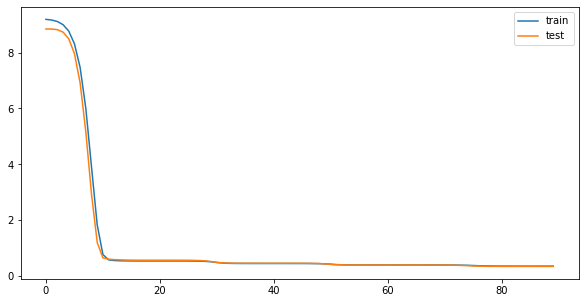

5330/5330 [==============================] - 1s 95us/sample - loss: 0.3467 - mse: 0.0123 - mae: 0.0926


2020-03-19 18:57:03,319 - wp - INFO - Validation Score: [0.3466646967193647, 0.012295615, 0.09256329]


In [13]:

keras_multinput = TsCNNLstm(logger=logger, verbose=2, batch_size=2000, epochs=90, lr=0.0001, l2_reg=0.05,
                                  sequence_length=60)
keras_multinput.find_categorical(df)
logger.info(df.head())
#df, ts, idz, y = keras_multinput.create_dataset(df)
#X_train, ts_train, y_train, X_valid, ts_valid, y_valid = keras_multinput.separate_train_valid(df, ts, idz, y)
keras_multinput.proces_categorical_columns(df)
X_train, ts_train, y_train, X_valid, ts_valid, y_valid = keras_multinput.load_pickled_data()
logger.info(X_train.head())
keras_multinput.model_setup()
keras_multinput.fit_data(show_figures=True)
keras_multinput.load_model()
ts_valid = pd.DataFrame(ts_valid.reshape(-1, keras_multinput.window_size * len(keras_multinput.non_categorical_columns)), index=X_valid.index)
ts_train = pd.DataFrame(ts_train.reshape(-1, keras_multinput.window_size * len(keras_multinput.non_categorical_columns)), index=X_train.index)
y_train = pd.DataFrame(y_train, index=X_train.index, columns=['Real Value'])
y_valid = pd.DataFrame(y_valid, index=X_valid.index, columns=['Real Value'])
lclids = list(set(np.unique(np.asarray(list(map(lambda t: t[0], X_train.index))))) & 
              set(np.unique(np.asarray(list(map(lambda t: t[0], X_valid.index))))))
lclid_test = list([lclids[i] for i in sorted(random.sample(range(len(lclids)), 4))])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']


2020-03-19 17:15:56,208 - wp - INFO - Predicting values for LCLID: MAC000073


2020-03-19 17:15:56,396 - wp - INFO - Predicting values for LCLID: MAC000124


2020-03-19 17:15:56,494 - wp - INFO - Predicting values for LCLID: MAC000108


2020-03-19 17:15:56,585 - wp - INFO - Predicting values for LCLID: MAC000048


Text(0, 0.5, 'Energy daily sum (kw.h)')

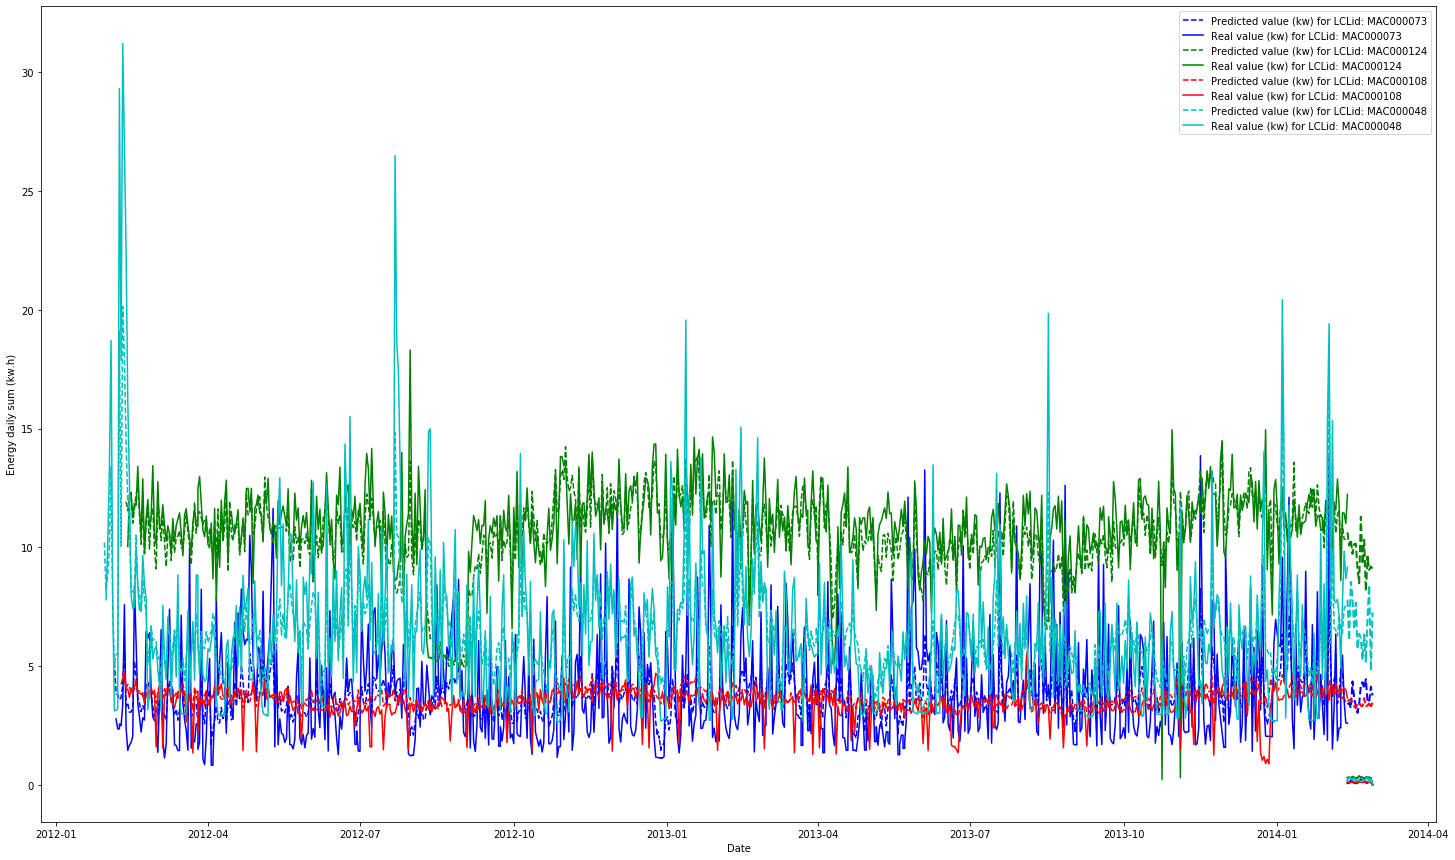

In [12]:
n  = keras_multinput.model.input[-1].name
keras_multinput.seq_name = n[:n.index(':')]

for lclid, clr in zip(lclid_test, colors[:len(lclid_test)]):

    logger.info(f'Predicting values for LCLID: {lclid}')
    X = X_train.loc[lclid, :]
    if (len(X) > 0):
        ts = ts_train.loc[lclid, :].values.reshape(-1, keras_multinput.n_steps, keras_multinput.window_size//keras_multinput.n_steps, len(keras_multinput.non_categorical_columns))
        y = keras_multinput.unscale_y_value(keras_multinput.predict(X, ts).reshape(-1, 1))
        y_pred = pd.DataFrame(y, index=y_train.loc[lclid, :].index, columns=['Predicted Value'])
        idx = list(
            [t + datetime.timedelta(days=TsCNNLstm.DAYS_AHEAD) for t in y_train.loc[lclid, :].index])
        y_real = pd.DataFrame(keras_multinput.unscale_y_value(y_train.loc[lclid, :]), index=idx,
                              columns=['Real Values'])

        plt.plot(y_pred, label=f'Predicted value (kw) for LCLid: {lclid}', linestyle='--', color=clr)
        plt.plot(y_real, label=f'Real value (kw) for LCLid: {lclid}', linestyle='-', color=clr)

    X = X_valid.loc[lclid, :]
    if (len(X) > 0):
        ts = ts_valid.loc[lclid, :].values.reshape(-1, keras_multinput.n_steps, keras_multinput.window_size//keras_multinput.n_steps, len(keras_multinput.non_categorical_columns))
        y = keras_multinput.unscale_y_value(keras_multinput.predict(X, ts).reshape(-1, 1))
        y_pred = pd.DataFrame(y, index=y_valid.loc[lclid, :].index, columns=['Predicted Value'])
        idx = list(
            [t + datetime.timedelta(days=TsCNNLstm.DAYS_AHEAD) for t in y_valid.loc[lclid, :].index])
        y_real = pd.DataFrame(keras_multinput.unscale_y_value(y_valid.loc[lclid, :]), index=idx,
                              columns=['Real Values'])

        plt.plot(y_pred, linestyle='--', color=clr, linewidth=2)
        plt.plot(y_valid.loc[lclid, :], linestyle='-', color=clr, linewidth=2)

plt.rcParams['figure.figsize'] = [35, 20]
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Energy daily sum (kw.h)')

